In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ***Dataset***

In [ ]:
milestone_dir = '/content/drive/MyDrive/DataSet/Milestone 2'
template_dir = '/content/drive/MyDrive/DataSet/Template images'

# ***Milestone Images***

In [ ]:
milestone_images = os.listdir(milestone_dir)
len(milestone_images)

8

In [ ]:
template_images = os.listdir(template_dir)
len(template_images)

12

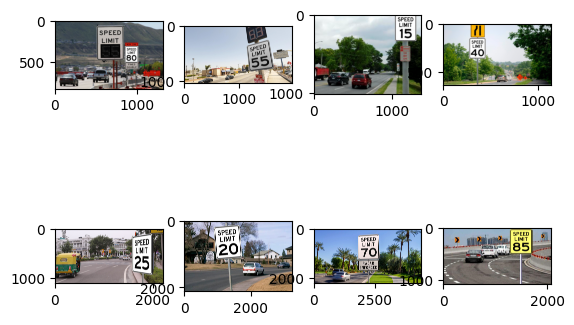

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 4)
axs = axs.flatten()
for i in range (len(milestone_images)):
    file_path = (os.path.join(milestone_dir, milestone_images[i]))
    img = Image.open(file_path)
    axs[i].imshow(img)
plt.show()

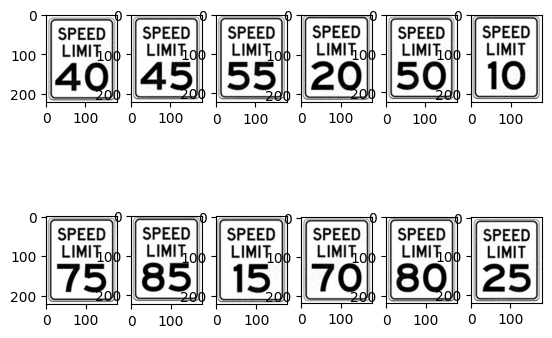

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 6)
axs = axs.flatten()
for i in range (len(template_images)):
    file_path = (os.path.join(template_dir, template_images[i]))
    img = Image.open(file_path)
    axs[i].imshow(img)
plt.show()

In [ ]:
milestone_images = sorted([f for f in os.listdir(milestone_dir) if f.endswith('.jpg')])
template_images = [f for f in os.listdir(template_dir) if f.endswith('.jpg')]

# ***Model***

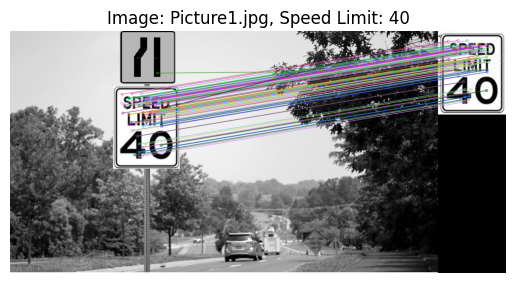

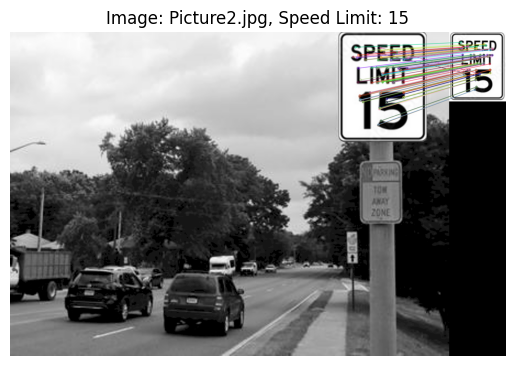

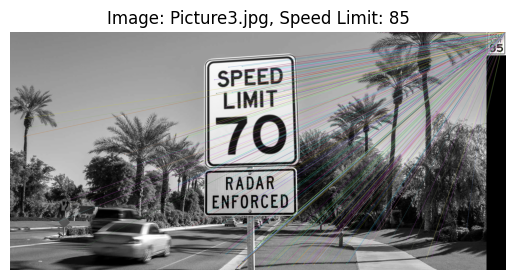

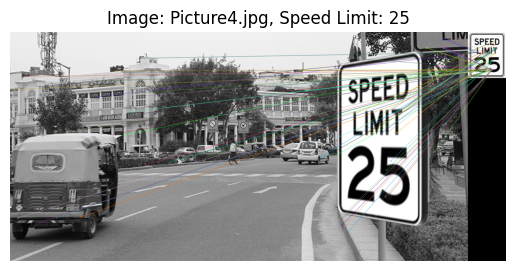

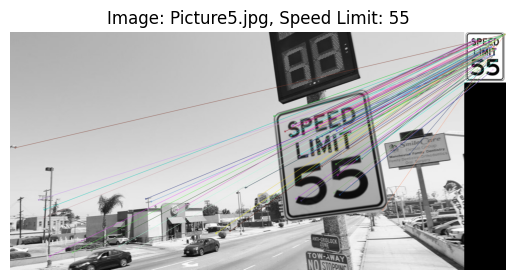

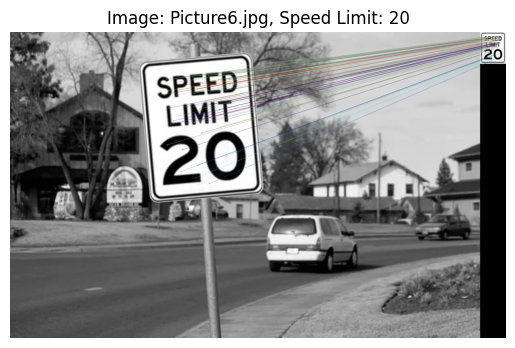

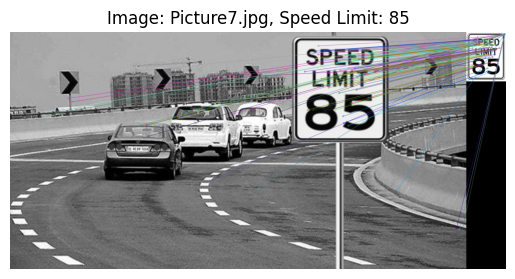

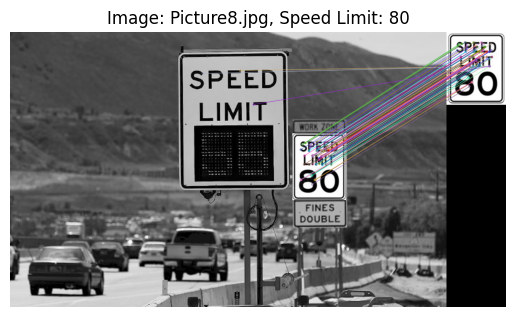

Output saved to M2_Output.csv:
     Image name  Speed limit
0  Picture1.jpg           40
1  Picture2.jpg           15
2  Picture3.jpg           85
3  Picture4.jpg           25
4  Picture5.jpg           55
5  Picture6.jpg           20
6  Picture7.jpg           85
7  Picture8.jpg           80


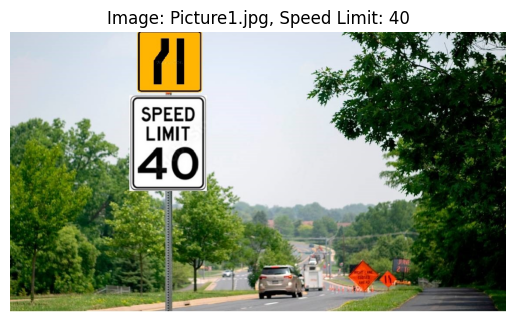

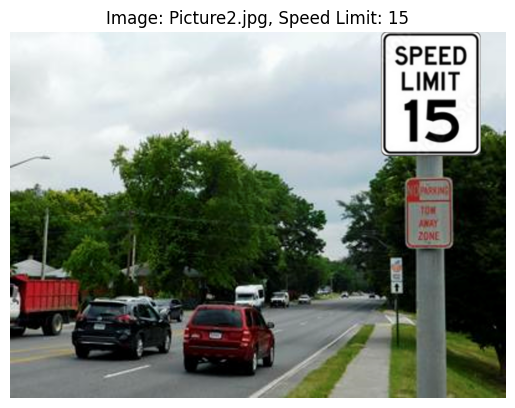

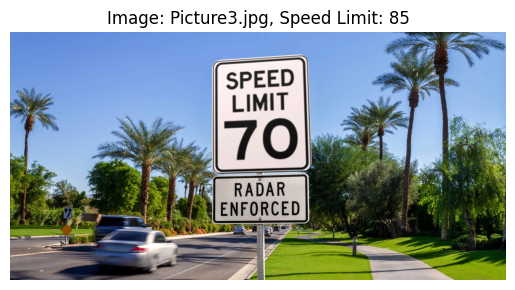

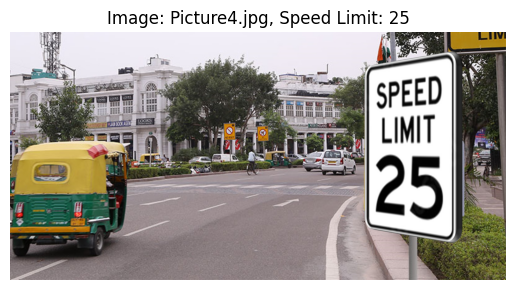

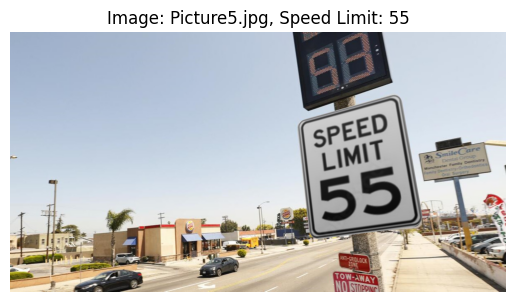

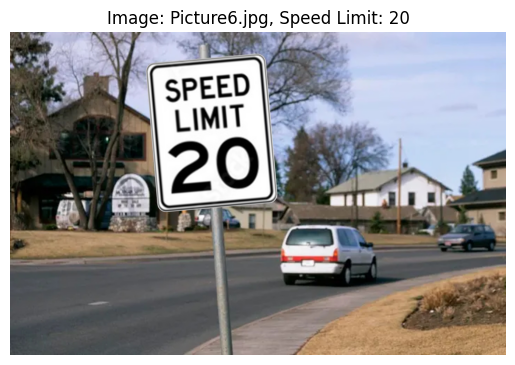

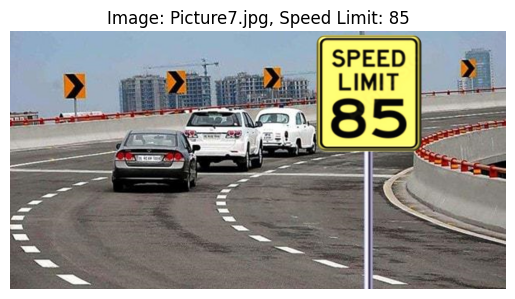

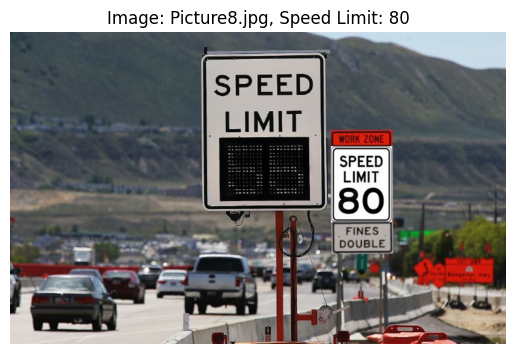

In [ ]:

# Initialize ORB and SIFT detectors
orb = cv2.ORB_create()
sift = cv2.SIFT_create()

output = []

# Function to detect and match keypoints, then apply homography
def detect_and_match(milestone_img, template_img, method='ORB'):
    if method == 'ORB':
        kp1, des1 = orb.detectAndCompute(milestone_img, None)
        kp2, des2 = orb.detectAndCompute(template_img, None)
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    elif method == 'SIFT':
        kp1, des1 = sift.detectAndCompute(milestone_img, None)
        kp2, des2 = sift.detectAndCompute(template_img, None)
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    if des1 is None or des2 is None:
        return 0, [], [], []

    matches = bf.knnMatch(des1, des2, k=2)
    good_matches = []

    for m, n in matches:
        if m.distance < 0.65 * n.distance:
            good_matches.append(m)

    if len(good_matches) > 4:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()
        return np.sum(matchesMask), good_matches, kp1, kp2
    else:
        return 0, good_matches, kp1, kp2


# Loop through milestone images
for milestone_fname in milestone_images:
    milestone_path = os.path.join(milestone_dir, milestone_fname)
    milestone_img = cv2.imread(milestone_path, cv2.IMREAD_GRAYSCALE)

    if milestone_img is None:
        print(f"Error loading image: {milestone_fname}")
        output.append([milestone_fname, None])
        continue

    found_speed_limit = None
    max_matches = 0

    # Loop through template images for template matching
    for template_fname in template_images:
        template_path = os.path.join(template_dir, template_fname)
        template_img = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)

        if template_img is None:
            print(f"Error loading template image: {template_fname}")
            continue

        orb_matches, orb_good_matches, orb_kp1, orb_kp2 = detect_and_match(milestone_img, template_img, method='ORB')
        sift_matches, sift_good_matches, sift_kp1, sift_kp2 = detect_and_match(milestone_img, template_img, method='SIFT')
        matches = max(orb_matches, sift_matches)

        if matches > max_matches:
            max_matches = matches
            found_speed_limit = int(template_fname.split('-')[1].split('.')[0])
            if sift_matches > orb_matches:
                best_matches = sift_good_matches
                best_kp1, best_kp2 = sift_kp1, sift_kp2
            else:
                best_matches = orb_good_matches
                best_kp1, best_kp2 = orb_kp1, orb_kp2
            best_template_img = template_img

    output.append([milestone_fname, found_speed_limit])

    # Visualize keypoints and matches
    if found_speed_limit is not None:
        img_matches = cv2.drawMatches(milestone_img, best_kp1, best_template_img, best_kp2, best_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(img_matches)
        plt.title(f"Image: {milestone_fname}, Speed Limit: {found_speed_limit}")
        plt.axis('off')
        plt.show()

# Save output to CSV
output_df = pd.DataFrame(output, columns=['Image name', 'Speed limit'])
output_csv_path = 'M2_Output.csv'
output_df.to_csv(output_csv_path, index=False)

# Display the CSV file content
print(f"Output saved to {output_csv_path}:")
print(output_df)

# Display images with matching results
for index, row in output_df.iterrows():
    milestone_path = os.path.join(milestone_dir, row['Image name'])
    milestone_img = cv2.imread(milestone_path)

    if milestone_img is not None:
        plt.imshow(cv2.cvtColor(milestone_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Image: {row['Image name']}, Speed Limit: {row['Speed limit']}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Error loading image: {row['Image name']}")
